In [2]:
# from collections import defaultdict
import numpy as np
import pandas as pd
import pymysql as mdb
import sqlalchemy
import random
import seaborn as sns
import matplotlib.pyplot as plt
from bisect import bisect

%matplotlib inline

sns.set_context('talk')
sns.set_style('darkgrid') 

In [3]:
# connect to sql
con = mdb.connect('localhost','root','','runnersdb')
cur = con.cursor()
sqlEngine = sqlalchemy.create_engine('mysql+pymysql://root@localhost/runnersdb')

In [4]:
# load good_runners which is highly filtered
good_runners = pd.read_sql("SELECT * FROM good_runners;",con)
good_runners['run_difficulty'] = good_runners['run_difficulty'].astype(int)

In [5]:
errors = []

In [6]:
s = 3
z_thresh = 0.5

In [7]:
grouped = good_runners.groupby(by=['user','race'])
patterns = []
for (u,r), group in grouped:
    df = grouped.get_group((u,r))
    patterns.append(df['run_difficulty'].tolist())

In [8]:
new_dict = {}
for line in patterns:
    zeroes = float(line.count(0))/len(line)
    if zeroes < z_thresh:
        l = len(line)
        for i in xrange(l-s):
            key = ''
            value = 0
            for j in xrange(s):
                n = str(line[i+j])
                key = key + n
            value = line[i+s]
            if key not in new_dict:
                new_dict[key] = [value]
            else:
                new_dict[key].append(value)   

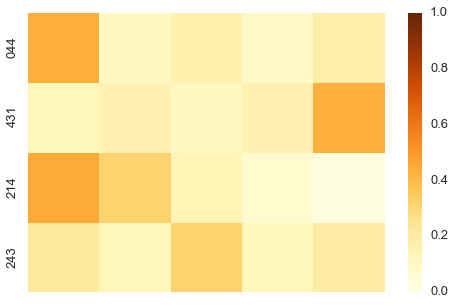

In [9]:
act_prob = pd.DataFrame()
for elem in new_dict:
    list_ = []
    for i in xrange(5):
        t = float(new_dict[elem].count(i))/len(new_dict[elem])
        list_.append(t)
    act_prob[elem] = list_
cur.execute("DROP TABLE IF EXISTS act_prob")
act_prob.to_sql('act_prob',sqlEngine)
act_prob = act_prob.rename(index={0:'rest',1:'easy',2:'moderate',3:'hard',4:'epic'})
plt.rcParams['figure.figsize'] = 8, 5  # plotsize 
subplot = act_prob[['044','431','214','243']]
sns.heatmap(subplot.T,annot=False,cbar=True,vmin=0,vmax=1,linewidths=0,yticklabels=True,xticklabels=False, cmap="YlOrBr")

In [10]:
# determine pdfs for all of the different run types
easy = []
mod = []
hard = []
epic = []
for i in xrange(len(good_runners['run_stress'])):
    stress = good_runners['run_stress'][i]
    diff = good_runners['run_difficulty'][i]
    if diff == 1:
        easy.append(stress)
    elif diff == 2:
        mod.append(stress)
    elif diff == 3:
        hard.append(stress)
    elif diff == 4:
        epic.append(stress)
easy_df = pd.DataFrame(easy)        
mod_df = pd.DataFrame(mod)        
hard_df = pd.DataFrame(hard)
epic_df = pd.DataFrame(epic)
      
# write to SQL    
cur.execute("DROP TABLE IF EXISTS easy_pdf")
easy_df.to_sql("easy_pdf",sqlEngine)
cur.execute("DROP TABLE IF EXISTS mod_pdf")
mod_df.to_sql("mod_pdf",sqlEngine)
cur.execute("DROP TABLE IF EXISTS hard_pdf")
hard_df.to_sql("hard_pdf",sqlEngine)
cur.execute("DROP TABLE IF EXISTS epic_pdf")
epic_df.to_sql("epic_pdf",sqlEngine)

In [11]:
pdf = {}
pdf[0] = [0]
for i in xrange(len(good_runners)):
    key = good_runners['run_difficulty'][i]
    value = good_runners['run_stress'][i]
    if key != 0:
        if key not in pdf:
            pdf[key] = [value]
        else:
            pdf[key].append(value)

In [12]:
# act_prob = pd.DataFrame()
# j = 2
# for elem in ld[j]:
#     list_ = []
#     for i in xrange(5):
#         t = float(ld[j][elem].count(i))/len(ld[j][elem])
#         list_.append(t)
#     act_prob[elem] = list_
# cur.execute("DROP TABLE IF EXISTS act_prob")
# act_prob.to_sql('act_prob',sqlEngine)
# # act_prob = act_prob.rename(index={0:'rest',1:'easy',2:'moderate',3:'hard',4:'epic'})
# plt.rcParams['figure.figsize'] = 10, 60  # plotsize 
# sns.heatmap(act_prob.T,annot=True,cbar=False,vmin=0,vmax=1)

In [13]:
# P = [0.10,0.25,0.60,0.05]

# cdf = [P[0]]
# for i in xrange(1, len(P)):
#     cdf.append(cdf[-1] + P[i])

# random_ind = bisect(cdf,random())
# random_ind

In [14]:
# test = '321'
# P = act_prob[test]
# cdf = [P[0]]
# for i in xrange(1, len(P)):
#     cdf.append(cdf[-1] + P[i])


In [15]:
classes = []
for key in new_dict:
    for num in new_dict[key]:
        classes.append([key, num])
classes = pd.DataFrame(classes)
classes = classes.rename(columns={0:'key',1:'num'})

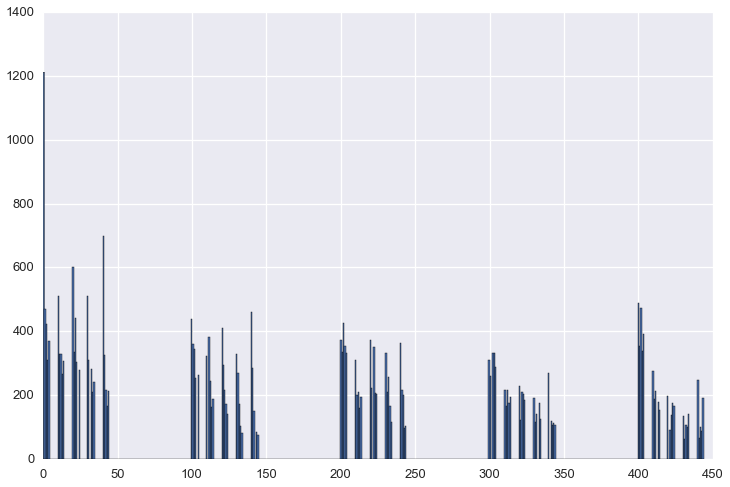

In [16]:
plt.rcParams['figure.figsize'] = 12, 8 
classes.key.astype(int).hist(bins=500)

In [17]:
def get_difficulty(prob_list,last_acts):
    diff = 0 
    probs = prob_list[last_acts]
    cdf = [probs[0]]
    for i in xrange(1,len(probs)):
        cdf.append(cdf[-1] + probs[i])
#     if last_acts == '000':
#         while (diff == 0): 
#             diff = bisect(cdf,random.random())
#     else:
#         diff = bisect(cdf,random.random())
    diff = bisect(cdf,random.random())
    return diff

In [18]:
# create test stats
test = pd.read_sql("SELECT days_to_marathon, run_difficulty FROM test_set;",con)
dt = {}
k=3
for i in xrange(len(test)-k):
    this_list = []
    key = ''
    value = 0
    day_test = test['days_to_marathon'][i+k]-test['days_to_marathon'][i]
    if day_test == k:
        for j in xrange(k):
            n = str(int(test['run_difficulty'][i+j]))
            key = key + n
        value = int(test['run_difficulty'][i+k])
        if key not in dt:
            dt[key] = [value]
        else:
            dt[key].append(value)

In [19]:
test = pd.read_sql("SELECT * FROM test_set;",con)

grouped_t = test.groupby(by=['user','race'])
z = []
for (u,r), group in grouped_t:
    df = grouped_t.get_group((u,r))
    z.append(df['run_difficulty'].tolist())
    
dt = {}
for line in z:
    zeroes = float(line.count(0))/len(line)
    if zeroes < z_thresh:
        l = len(line)
        for i in xrange(l-s):
            key = ''
            value = 0
            for j in xrange(s):
                n = str(int(line[i+j]))
                key = key + n
            value = int(line[i+s])
            if key not in dt:
                dt[key] = [value]
            else:
                dt[key].append(value)   

In [20]:
classes = []
for key in dt:
    for num in dt[key]:
        classes.append([key, num])
classes = pd.DataFrame(classes)
classes = classes.rename(columns={0:'key',1:'num'})

In [21]:
stuff = pd.read_sql("SELECT * FROM act_prob;",con)
preds = []
for i in xrange(len(classes)):
    key = classes.key[i]
    num = get_difficulty(stuff,key)
    preds.append(num)
preds = pd.DataFrame(preds)
preds = preds.rename(columns={0:'prediction'})

In [22]:
full = pd.concat([classes, preds], axis=1)
rests = []
easies = []
mods = []
hards = []
epics = []
for i in xrange(len(full)):
    num = full['num'][i]
    pred = full['prediction'][i]
    if num == 0:
        rests.append(pred)
    elif num == 1:
        easies.append(pred)
    elif num == 2:
        mods.append(pred)
    elif num == 3:
        hards.append(pred)
    elif num == 4:
        epics.append(pred)

In [23]:
confusion = pd.DataFrame()
full = [rests,easies,mods,hards,epics]
for elem in full:
    list_ = []
    for i in xrange(5):
        t = float(elem.count(i))/len(elem)
#         t = float(elem.count(i))#/len(elem)
        list_.append(t)
    confusion = confusion.append([list_])
confusion = confusion.reset_index()
del confusion['index']

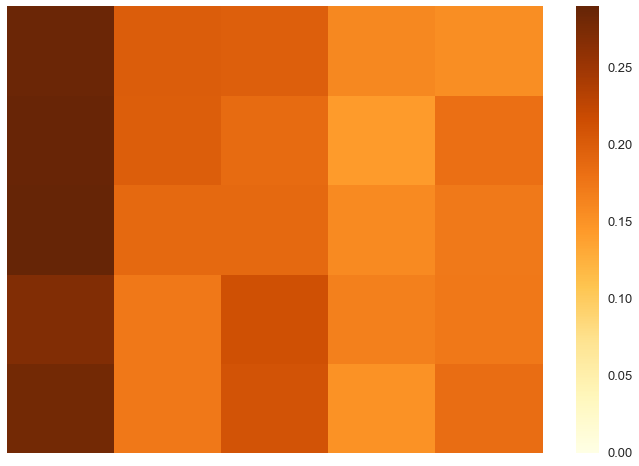

In [24]:
# correlation matrix
# sns.heatmap(confusion,annot=False,cbar=True,vmin=0,vmax=confusion.max().max(),fmt='g',cmap="YlOrBr",linewidths=0)
sns.heatmap(confusion,annot=False,cbar=True,vmin=0,vmax=confusion.max().max(),fmt='g',cmap="YlOrBr",linewidths=0,xticklabels=False,yticklabels=False)

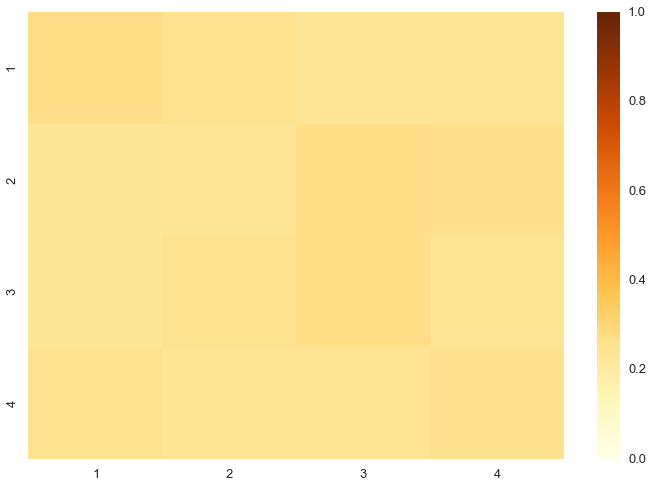

In [25]:
subfusion = confusion[1:5][[1,2,3,4]]
rows = []
for line in subfusion:
    newline = subfusion[line]/subfusion[line].sum()
    rows.append(newline)
subfusionp = pd.DataFrame(rows)    
sns.heatmap(subfusionp,annot=False,cbar=True,vmin=0,vmax=1,fmt='g',cmap="YlOrBr",linewidths=0)

In [26]:
# err_df = pd.DataFrame(errors,columns=('threshold','accuracy'))
# err_df.plot(x='threshold',y='accuracy',legend=False)

In [27]:
confusion2 = confusion.T
# full = [rests,easies,mods,hards,epics]
new_mat = []
for row in confusion:
    new_row = confusion[row]
    new_row = new_row/new_row.sum()
    new_mat.append(new_row)
    print new_row
# list_2 = []
# for i in xrange(5):
#     t = float(elem.count(i))/len(elem)
#     list_2.append(t)
# confusion = confusion.append([list_])
# confusion = confusion.reset_index()
# del confusion['index']

0    0.202080
1    0.203878
2    0.204994
3    0.190984
4    0.198065
Name: 0, dtype: float64
0    0.213952
1    0.212798
2    0.201811
3    0.186097
4    0.185342
Name: 1, dtype: float64
0    0.198529
1    0.186862
2    0.189252
3    0.214349
4    0.211008
Name: 2, dtype: float64
0    0.205398
1    0.184039
2    0.202478
3    0.214516
4    0.193569
Name: 3, dtype: float64
0    0.178371
1    0.209279
2    0.200006
3    0.200211
4    0.212133
Name: 4, dtype: float64


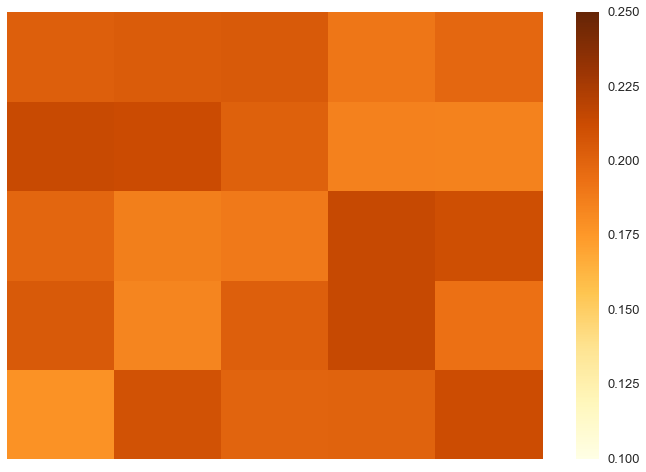

In [28]:
# sns.heatmap(new_mat,annot=False,cbar=True,vmin=0,vmax=confusion.max().max(),fmt='g',cmap="YlOrBr",linewidths=0,xticklabels=False,yticklabels=False)
sns.heatmap(new_mat,annot=False,cbar=True,vmin=0.1,vmax=0.25,fmt='g',cmap="YlOrBr",linewidths=0,xticklabels=False,yticklabels=False)

In [1]:
new_mat

NameError: name 'new_mat' is not defined

In [ ]:
# create dict containing chain algorithm for different size chains
filling = []
max_chain = 11
ld = []
for k in range(1,max_chain+1):
    d = {}
    for i in xrange(len(good_runners)-k):
        this_list = []
        key = ''
        value = 0
        day_test = good_runners['days_to_marathon'][i+k]-good_runners['days_to_marathon'][i]
        if day_test == k:
            for j in xrange(k):
                n = str(good_runners['run_difficulty'][i+j])
                key = key + n
            value = good_runners['run_difficulty'][i+k]
            if key not in d:
                d[key] = [value]
            else:
                d[key].append(value)
    ld.append(d)     
    filling.append([k,float(len(d))/(5 ** k)*100])

In [ ]:
# Plot chain size with %filled
plt.rcParams['figure.figsize'] = 12, 8
hold = pd.DataFrame(filling)#.plot()
del hold[0]
hold.plot(legend=False)

In [97]:
intensity = pd.read_sql("SELECT * FROM intensity;",con)
del intensity['index']

In [111]:
easy_int = []
mod_int = []
hard_int = []
epic_int = []
for i in xrange(len(intensity)):
    diff = intensity['run_difficulty'][i]
    intens = intensity['intensity'][i]
    if diff == 1:
        easy_int.append(intens)
    elif diff == 2:
        mod_int.append(intens)
    elif diff == 3:
        hard_int.append(intens)
    elif diff == 4:
        epic_int.append(intens)
easy_int = pd.DataFrame(easy_int)
mod_int = pd.DataFrame(mod_int)
hard_int = pd.DataFrame(hard_int)
epic_int = pd.DataFrame(epic_int)

In [112]:
cur.execute("DROP TABLE IF EXISTS easy_ints")
cur.execute("DROP TABLE IF EXISTS mod_ints")
cur.execute("DROP TABLE IF EXISTS hard_ints")
cur.execute("DROP TABLE IF EXISTS epic_ints")
easy_int.to_sql('easy_ints',sqlEngine)
mod_int.to_sql('mod_ints',sqlEngine)
hard_int.to_sql('hard_ints',sqlEngine)
epic_int.to_sql('epic_ints',sqlEngine)

/Users/Eddie/anaconda/lib/python2.7/site-packages/pymysql/cursors.py:134: Warning: Unknown table 'runnersdb.easy_ints'
  result = self._query(query)
/Users/Eddie/anaconda/lib/python2.7/site-packages/pymysql/cursors.py:134: Warning: Unknown table 'runnersdb.mod_ints'
  result = self._query(query)
/Users/Eddie/anaconda/lib/python2.7/site-packages/pymysql/cursors.py:134: Warning: Unknown table 'runnersdb.hard_ints'
  result = self._query(query)
/Users/Eddie/anaconda/lib/python2.7/site-packages/pymysql/cursors.py:134: Warning: Unknown table 'runnersdb.epic_ints'
  result = self._query(query)
